## Anomaly Detection for NYC Taxi & Limousine Data

In [1]:
import numpy as np
import pandas as pd
import geopandas as gp
from geopandas import GeoDataFrame
import os
from shapely.geometry import Point
from datetime import datetime
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.metrics import roc_auc_score as rs
from sklearn import svm, datasets
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import IsolationForest
from pandas.tseries.holiday import USFederalHolidayCalendar
from mpl_toolkits.mplot3d import Axes3D
#import pickle

np.random.seed(222)

%matplotlib inline
%pylab inline
pd.options.display.max_columns = 120
pd.options.display.max_rows = 120

Populating the interactive namespace from numpy and matplotlib


/home/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
proj_folder = os.getcwd()
data_folder_external = proj_folder + '/data'
data_folder_external

'/wingrdp/homedirs/gtp232/machine_learning/anomaly_detection_NYC_transit/data'

## TLC anomaly detection

## Notes 4-22-17
Next steps:
1. would love to look at different areas of the city and see where the anomalies relative to those places
i.e. taxi trips to/from coney island would be interesting / or around MSG - "concert superstorm?"

## Notes 4-26-17
Next steps:
1. add day of week analysis 
2. add more months of data

## Notes 4-28-17
Next steps:
1. account for holidays 
http://jakevdp.github.io/blog/2015/07/23/learning-seattles-work-habits-from-bicycle-counts/
2. account for day of the week
3. add another anomaly detection model?

In [4]:
### read in data for 2015
'''
taken from
http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml
NOTE: after june 2016, the data no longer has lat / lons, only has neighborhoods
'''

columns = ['passenger_count', 'trip_distance', 'fare_amount', \
                     'extra', 'mta_tax', 'tip_amount', 'total_amount', \
                     'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'pickup_longitude',\
                     'pickup_latitude']
tlc_df_raw_total = pd.DataFrame(columns = columns)
for i in range(1,10):
    print i
    tlc_df_raw = pd.read_csv(data_folder_external + '/tlc_yellow_2015_0' + str(i) + '.csv', usecols=['passenger_count', \
                    'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'total_amount', \
                     'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'pickup_longitude', 'pickup_latitude'])
    tlc_df_raw['tpep_pickup_datetime'] = pd.to_datetime(tlc_df_raw['tpep_pickup_datetime'])
    tlc_df_raw['tpep_dropoff_datetime'] = pd.to_datetime(tlc_df_raw['tpep_dropoff_datetime'])
    tlc_df_raw_total = tlc_df_raw_total.append(tlc_df_raw, ignore_index=True)

for i in range(10,13):
    print i
    tlc_df_raw = pd.read_csv(data_folder_external + '/tlc_yellow_2015_' + str(i) + '.csv', usecols=['passenger_count', \
                    'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'total_amount', \
                     'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'pickup_longitude', 'pickup_latitude'])
    tlc_df_raw['tpep_pickup_datetime'] = pd.to_datetime(tlc_df_raw['tpep_pickup_datetime'])
    tlc_df_raw['tpep_dropoff_datetime'] = pd.to_datetime(tlc_df_raw['tpep_dropoff_datetime'])
    tlc_df_raw_total = tlc_df_raw_total.append(tlc_df_raw, ignore_index=True)


1
2
3
4
5
6
7
8
9
10
11
12


In [5]:
len(tlc_df_raw_total)

146112989

In [6]:
tlc_df_raw_total.head()

,extra,fare_amount,mta_tax,passenger_count,pickup_latitude,pickup_longitude,tip_amount,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance
0,1.0,12.0,0.5,1.0,40.750111,-73.993896,3.25,17.05,2015-01-15 19:23:42,2015-01-15 19:05:39,1.59
1,0.5,14.5,0.5,1.0,40.724243,-74.001648,2.00,17.80,2015-01-10 20:53:28,2015-01-10 20:33:38,3.30
2,0.5,9.5,0.5,1.0,40.802788,-73.963341,0.00,10.80,2015-01-10 20:43:41,2015-01-10 20:33:38,1.80
3,0.5,3.5,0.5,1.0,40.713818,-74.009087,0.00,4.80,2015-01-10 20:35:31,2015-01-10 20:33:39,0.50
4,0.5,15.0,0.5,1.0,40.762428,-73.971176,0.00,16.30,2015-01-10 20:52:58,2015-01-10 20:33:39,3.00


In [6]:
#CANNOT GET THIS TRIP DURATION TO WORK - MOVING ON FOR NOW
#tlc_df['trip_duration'] = pd.Timedelta(tlc_df['tpep_dropoff_datetime_2'] - tlc_df['tpep_pickup_datetime']).seconds / 3600.0
#tlc_df['trip_speed'] = tlc_df.trip_distance / tlc_df.trip_duration

## Clean the data - 
drop all the unreasonable trip entries, such as those that have trip distance in the millions of miles

In [7]:
#only keep trips that have a positive distance less than 100 miles
tlc_df_total = tlc_df_raw_total[(tlc_df_raw_total.trip_distance > 0) & (tlc_df_raw_total.trip_distance < 100)]

#only keep trips that have a positive fare amount less than $500
tlc_df_total = tlc_df_total[(tlc_df_total.fare_amount > 0) & (tlc_df_total.fare_amount < 500)]

#only keep trips that have a positive tip amount less than $1000
tlc_df_total = tlc_df_total[(tlc_df_total.tip_amount >= 0) & (tlc_df_total.tip_amount < 1000)]

In [9]:
len(tlc_df_total) * 1.0 / len(tlc_df_raw_total)

0.9931872175991143

In [10]:
#count the number of taxi trips each day
tlc_df_total['taxi_date'] = tlc_df_total['tpep_pickup_datetime'].dt.date
tlc_df_day_count = tlc_df_total.groupby(['taxi_date'], as_index=False)['extra'].count()
tlc_df_day_count.columns = ['taxi_date', 'taxi_trip_count']

In [11]:
#take the mean of the taxi stats each day
tlc_df_stat_agg = tlc_df_total.groupby(['taxi_date'], as_index=False).mean()
tlc_df_stat_agg.head()

,taxi_date,extra,fare_amount,mta_tax,passenger_count,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance
0,2015-01-01,0.270273,12.657806,0.497992,1.809730,39.943048,-72.508607,1.282963,15.247579,3.255304
1,2015-01-02,0.397660,12.064885,0.498283,1.758867,39.959375,-72.536360,1.262980,14.796527,2.963635
2,2015-01-03,0.194821,11.577505,0.498651,1.777010,40.090698,-72.778421,1.273699,14.058896,2.846575
3,2015-01-04,0.189877,12.634198,0.498123,1.722101,40.200017,-72.973559,1.492329,15.445016,3.332494
4,2015-01-05,0.371148,12.149376,0.498688,1.655208,40.032467,-72.664518,1.511471,15.148335,3.033297


In [13]:
tlc_df_by_day = tlc_df_stat_agg.merge(tlc_df_day_count, on='taxi_date')
tlc_df_by_day.head()

,taxi_date,extra,fare_amount,mta_tax,passenger_count,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance,taxi_trip_count
0,2015-01-01,0.270273,12.657806,0.497992,1.809730,39.943048,-72.508607,1.282963,15.247579,3.255304,378940
1,2015-01-02,0.397660,12.064885,0.498283,1.758867,39.959375,-72.536360,1.262980,14.796527,2.963635,343093
2,2015-01-03,0.194821,11.577505,0.498651,1.777010,40.090698,-72.778421,1.273699,14.058896,2.846575,404372
3,2015-01-04,0.189877,12.634198,0.498123,1.722101,40.200017,-72.973559,1.492329,15.445016,3.332494,326536
4,2015-01-05,0.371148,12.149376,0.498688,1.655208,40.032467,-72.664518,1.511471,15.148335,3.033297,360646


In [14]:
tlc_df_by_day['day_of_week'] = tlc_df_by_day.taxi_date.apply(lambda x: x.weekday())

In [15]:
#control for Friday / Saturday nights
tlc_df_by_day['weekend'] = 0
tlc_df_by_day['weekend'][(tlc_df_by_day['day_of_week'] == 4) | (tlc_df_by_day['day_of_week'] == 5)] = 1

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Add Feature for Holidays

In [16]:
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016', return_name=True)
holidays.name = 'name'
holidays.head()

2012-01-02                 New Years Day
2012-01-16    Dr. Martin Luther King Jr.
2012-02-20                Presidents Day
2012-05-28                   MemorialDay
2012-07-04                      July 4th
Name: name, dtype: object

In [17]:
holidays_all = pd.concat([holidays,
                         "Day Before " + holidays.shift(-1, 'D'),
                         "Day After " + holidays.shift(1, 'D')])
holidays_all = holidays_all.sort_index()

In [18]:
#add holiday dummy variable
tlc_df_by_day['holiday'] = 0
tlc_df_by_day['holiday'][tlc_df_by_day['taxi_date'].isin(holidays_all.index.date)] = 1

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
tlc_df_by_day.head()

,taxi_date,extra,fare_amount,mta_tax,passenger_count,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance,taxi_trip_count,day_of_week,weekend,holiday
0,2015-01-01,0.270273,12.657806,0.497992,1.809730,39.943048,-72.508607,1.282963,15.247579,3.255304,378940,3,0,1
1,2015-01-02,0.397660,12.064885,0.498283,1.758867,39.959375,-72.536360,1.262980,14.796527,2.963635,343093,4,1,1
2,2015-01-03,0.194821,11.577505,0.498651,1.777010,40.090698,-72.778421,1.273699,14.058896,2.846575,404372,5,1,0
3,2015-01-04,0.189877,12.634198,0.498123,1.722101,40.200017,-72.973559,1.492329,15.445016,3.332494,326536,6,0,0
4,2015-01-05,0.371148,12.149376,0.498688,1.655208,40.032467,-72.664518,1.511471,15.148335,3.033297,360646,0,0,0


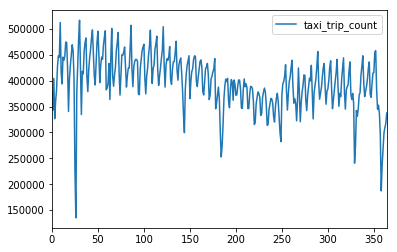

In [20]:
tlc_df_by_day[['taxi_date', 'taxi_trip_count']].plot()

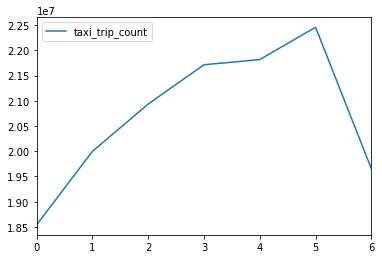

In [21]:
'''
0 is a Monday
1 is tuesday etc etc
'''
tlc_df_by_day_agg = tlc_df_by_day.groupby(['day_of_week'], as_index=False).sum()
tlc_df_by_day_agg[['taxi_trip_count']].plot()

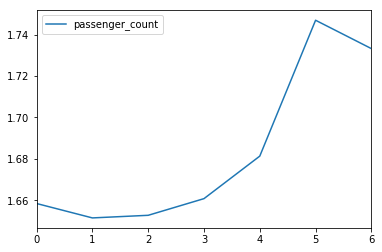

In [22]:
tlc_df_by_day_avg = tlc_df_by_day.groupby(['day_of_week'], as_index=False).mean()
tlc_df_by_day_avg[['passenger_count']].plot()

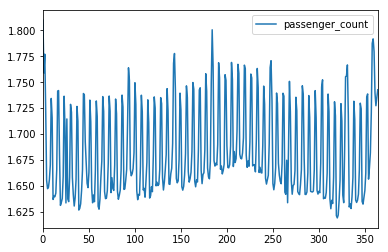

In [23]:
tlc_df_by_day[['taxi_date', 'passenger_count']].plot()

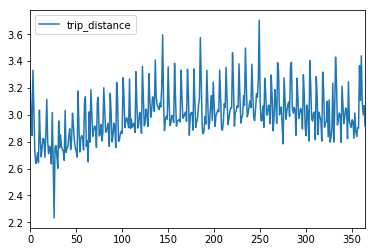

In [24]:
tlc_df_by_day[['taxi_date', 'trip_distance']].plot()

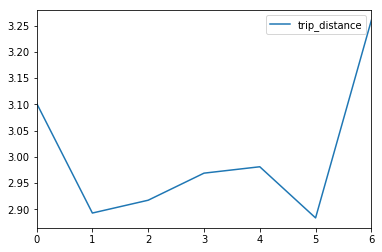

In [25]:
tlc_df_by_day_avg[['trip_distance']].plot()

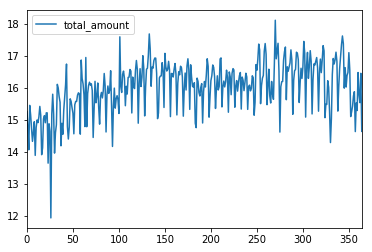

In [26]:
tlc_df_by_day[['taxi_date', 'total_amount']].plot()

## Pickle Main Pandas DFs for easy recovery in the future

In [27]:
# tlc_df_by_day.to_pickle('tlc_df_by_day.pkl')  # where to save it, usually as a .pkl

In [28]:
# tlc_df_total.shape

In [29]:
# n_partitions = 500
# partition_size = len(tlc_df_total) / n_partitions
# for i in range(0,n_partitions+1):
#     print i
#     tlc_df_total_subset = tlc_df_total.iloc[(i*partition_size):((i+1)*partition_size), :]
#     tlc_df_total_subset.to_pickle('tlc_df_total_' + str(i) + '.pkl')  # where to save it, usually as a .pkl

## Clustering Anomaly Detection

In [30]:
# file = open('tlc_df_by_day.pkl','rb')
# tlc_df_by_day = pickle.load(file)
# file.close()

In [31]:
# tlc_df_by_day.head()

In [32]:
cluster_features = ['total_amount', 'taxi_trip_count', 'holiday', 'weekend']

In [33]:
X = tlc_df_by_day[cluster_features]
X.head(2)

,total_amount,taxi_trip_count,holiday,weekend
0,15.247579,378940,1,0
1,14.796527,343093,1,1


### K-Means Cluster Model Anomaly Detection

In [34]:
#normalize columns
for i in X.columns:
    X[i] = (X[i] - X[i].mean()) / X[i].std()
    
X.head()

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,total_amount,taxi_trip_count,holiday,weekend
0,-0.926054,-0.362853,3.337076,-0.630377
1,-1.482893,-1.060577,3.337076,1.582005
2,-2.393524,0.132154,-0.298843,1.582005
3,-0.682311,-1.382841,-0.298843,-0.630377
4,-1.048574,-0.718927,-0.298843,-0.630377


In [35]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.416780148734
For n_clusters =3, the average silhouette_score is :0.498464343688
For n_clusters =4, the average silhouette_score is :0.468578606773
For n_clusters =5, the average silhouette_score is :0.374899206652
For n_clusters =6, the average silhouette_score is :0.380861227689
For n_clusters =7, the average silhouette_score is :0.390911887617
For n_clusters =8, the average silhouette_score is :0.385772642625


In [36]:
n=3
KM=KMeans(n_clusters=n,random_state=999)
scor=KM.fit_predict(X)

res=pd.DataFrame(KM.transform(X))
res=pd.concat((res,pd.DataFrame(KM.fit_predict(X))),axis=1)
res.columns=list(range(n))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

In [37]:
tlc_df_by_day['cluster'] = res.cluster
tlc_df_by_day['km_score'] = res.score
tlc_df_by_day['outlier'] = 0
tlc_df_by_day.sort_values("km_score",ascending=False, inplace=True)

In [38]:
tlc_df_by_day['outlier'][:10] = 1 

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [39]:
def set_color(Data1):
    if (Data1.outlier == 1):
        return "red"
    elif (Data1.cluster == 0):
        return "blue"
    elif (Data1.cluster == 1):
        return "cyan"
    else:
        return "green"

tlc_df_by_day = tlc_df_by_day.assign(color=tlc_df_by_day.apply(set_color, axis=1))

In [40]:
X.head()

,total_amount,taxi_trip_count,holiday,weekend
0,-0.926054,-0.362853,3.337076,-0.630377
1,-1.482893,-1.060577,3.337076,1.582005
2,-2.393524,0.132154,-0.298843,1.582005
3,-0.682311,-1.382841,-0.298843,-0.630377
4,-1.048574,-0.718927,-0.298843,-0.630377


In [41]:
tlc_df_by_day.head()

,taxi_date,extra,fare_amount,mta_tax,passenger_count,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance,taxi_trip_count,day_of_week,weekend,holiday,cluster,km_score,outlier,color
26,2015-01-27,0.534315,9.281400,0.499611,1.714553,40.134412,-72.851410,1.241452,11.932300,2.231997,134820,1,0,0,2,6.817219,1,red
25,2015-01-26,0.181358,11.852456,0.498361,1.633555,40.019998,-72.641121,1.551247,14.640396,2.650079,228457,0,0,0,0,3.696080,1,red
358,2015-12-25,0.187647,12.892594,0.498300,1.787423,40.295980,-73.140749,1.317086,15.520742,3.366423,187033,4,1,1,2,3.359355,1,red
45,2015-02-15,0.199551,11.764277,0.498740,1.737745,39.943665,-72.515130,1.440457,14.395028,2.813677,456102,6,0,1,2,2.769782,1,red
270,2015-09-28,0.369048,14.525026,0.498052,1.654874,40.269218,-73.097246,1.975186,18.102169,3.325909,320770,0,0,0,0,2.703128,1,red


In [42]:
tlc_df_by_day_w_z_scores = tlc_df_by_day.merge(X, left_index=True, right_index=True)

In [43]:
tlc_df_by_day_w_z_scores.sort_values("km_score",ascending=False, inplace=True)
tlc_df_by_day_w_z_scores[['taxi_date', 'km_score',  'total_amount_x',\
                          'taxi_trip_count_x', 'holiday_x', 'weekend_x', \
                                    'total_amount_y', 'taxi_trip_count_y', 'holiday_y', 'weekend_y']].head(15)

,taxi_date,km_score,total_amount_x,taxi_trip_count_x,holiday_x,weekend_x,total_amount_y,taxi_trip_count_y,holiday_y,weekend_y
26,2015-01-27,6.817219,11.932300,134820,0,0,-5.018880,-5.114389,-0.298843,-0.630377
25,2015-01-26,3.696080,14.640396,228457,0,0,-1.675642,-3.291845,-0.298843,-0.630377
358,2015-12-25,3.359355,15.520742,187033,1,1,-0.588825,-4.098119,3.337076,1.582005
45,2015-02-15,2.769782,14.395028,456102,1,0,-1.978557,1.139023,3.337076,-0.630377
270,2015-09-28,2.703128,18.102169,320770,0,0,2.598035,-1.495070,-0.298843,-0.630377
9,2015-01-10,2.655876,13.884081,512258,0,1,-2.609339,2.232040,-0.298843,1.582005
30,2015-01-31,2.635218,13.955886,516806,0,1,-2.520694,2.320562,-0.298843,1.582005
359,2015-12-26,2.595780,15.284123,237105,1,1,-0.880939,-3.123521,3.337076,1.582005
330,2015-11-27,2.581628,14.284729,273491,1,1,-2.114726,-2.415306,3.337076,1.582005
184,2015-07-04,2.535562,14.749383,252645,1,1,-1.541094,-2.821051,3.337076,1.582005


In [44]:
z_score = tlc_df_by_day_w_z_scores[['taxi_date', 'km_score',  'total_amount_x',\
                          'taxi_trip_count_x', 'holiday_x', 'weekend_x', \
                                    'total_amount_y', 'taxi_trip_count_y', 'holiday_y', 'weekend_y']]
z_score.sort_values("km_score",ascending=False, inplace=True)
z_score.to_csv('tlc_clustered_by_day_w_z_scores.csv')

In [45]:
cluster_features

['total_amount', 'taxi_trip_count', 'holiday', 'weekend']

In [46]:
KM.cluster_centers_

array([[ 0.25798219, -0.14190723, -0.29884258, -0.63037746],
       [-0.41305126,  0.73872152, -0.29884258,  1.58200497],
       [-0.65821851, -1.25498717,  3.21978784, -0.20217441]])

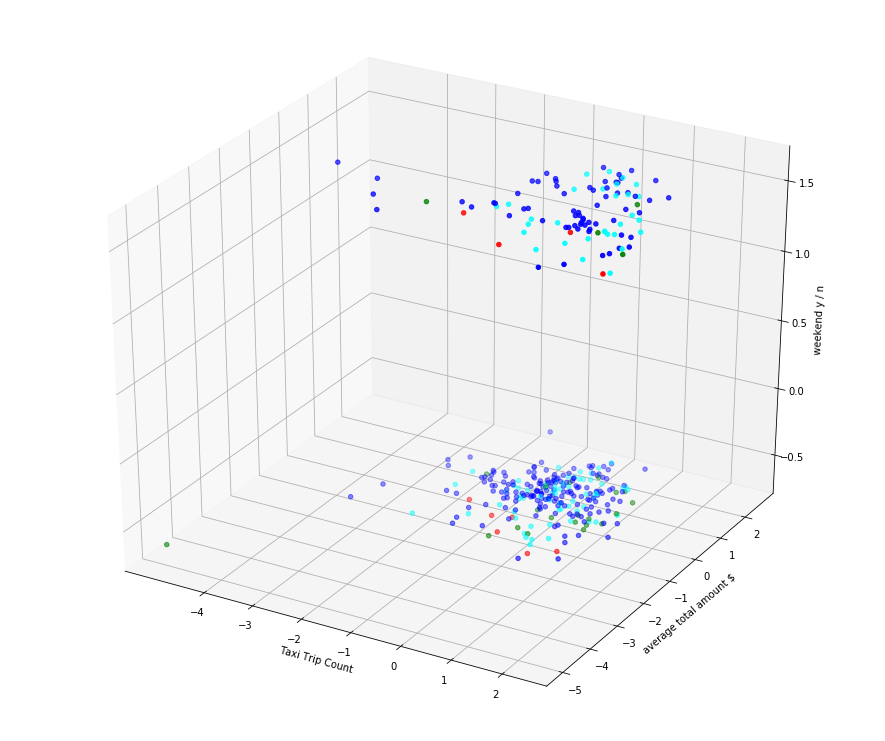

In [47]:
fig = plt.figure(figsize=(12,10))
ax = Axes3D(fig)

ax.scatter(X.taxi_trip_count, X.total_amount, X.weekend, c=tlc_df_by_day.color)
ax.set_xlabel('Taxi Trip Count')
ax.set_ylabel('average total amount $')
ax.set_zlabel('weekend y / n')
# set x ticks and labels
ax.set_xticks(range(-4, 3, 1))
# change fontsize
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(10)
plt.show()

## Isolation Anomaly Detection

### Isolation Forest Anomaly Detection

In [48]:
train,test=train_test_split(X, random_state=999, test_size=0.3)
# fit the model
clf = IsolationForest(max_samples=100, random_state=999)
clf.fit(train)
y_pred = clf.predict(X)

In [49]:
z_score['decision_function'] = clf.decision_function(X)

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [51]:
z_score.sort_values("km_score",ascending=False, inplace=True)
z_score.to_csv('tlc_clustered_by_day_w_z_scores.csv')

## January 18 has high payments for some reason... investigate

In [52]:
df_1_18 = tlc_df_total[tlc_df_total.taxi_date == datetime.date(2015,1,18)]

In [53]:
df_1_18.sort_values(by='total_amount', ascending=False).head()

,extra,fare_amount,mta_tax,passenger_count,pickup_latitude,pickup_longitude,tip_amount,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance,taxi_date
5900871,606.12,82.0,0.5,1.0,40.758495,-73.982208,0.00,688.92,2015-01-18 02:56:05,2015-01-18 02:39:09,10.00,2015-01-18
5802097,0.00,350.0,0.5,1.0,40.644112,-73.790398,75.13,451.59,2015-01-18 18:30:54,2015-01-18 16:41:09,65.45,2015-01-18
5348432,0.00,325.0,0.0,1.0,40.660809,-73.805481,25.00,360.96,2015-01-18 16:45:23,2015-01-18 14:55:34,75.63,2015-01-18
961472,0.00,9.5,0.5,2.0,40.757351,-73.972145,350.00,360.30,2015-01-18 13:55:38,2015-01-18 13:42:14,1.20,2015-01-18
3392622,0.00,297.0,0.0,2.0,40.642254,-73.789291,0.00,314.38,2015-01-18 13:30:23,2015-01-18 11:16:31,77.70,2015-01-18


## Look at specific areas and see what times / dates around there are anomalies
### Madison Square Gardens (40.750556, -73.993611)

In [54]:
latlon_list = [40.750556, -73.993611]
#only keep trips within a reasonable pickup lat / lon (without converting geometries)
tlc_df_total_subset = tlc_df_total[(tlc_df_total.pickup_latitude > (latlon_list[0] - 0.005)) & (tlc_df_total.pickup_latitude < (latlon_list[0] + 0.005))]
tlc_df_total_subset = tlc_df_total_subset[(tlc_df_total_subset.pickup_longitude > (latlon_list[1] - 0.005)) & (tlc_df_total_subset.pickup_longitude < (latlon_list[1] + 0.005))]

In [55]:
# convert to geopandas df
geometry = [Point(xy) for xy in zip(tlc_df_total_subset.pickup_longitude, tlc_df_total_subset.pickup_latitude)]

In [56]:
crs = {'init': 'epsg:4326'}
tlc_df_total_gp = GeoDataFrame(tlc_df_total_subset, crs=crs, geometry=geometry)

In [57]:
# create MSG buffer 
d = {'latitude': latlon_list[0], 'longitude': latlon_list[1]}
MSG = pd.DataFrame(data=d, index=[0])
geometry_MSG = [Point(xy) for xy in zip(MSG.longitude, MSG.latitude)]
crs = {'init': 'epsg:4326'}
MSG_gp = GeoDataFrame(crs=crs, geometry=geometry_MSG)

In [58]:
#create buffer
MSG_gp['geometry'] = MSG_gp.geometry.buffer(.005)
MSG_gp.head()

,geometry
0,"POLYGON ((-73.98861100000001 40.750556, -73.98..."


In [59]:
# only keep points within MSG buffer
tlc_df_total_gp_subset = tlc_df_total_gp[tlc_df_total_gp.geometry.intersects(MSG_gp.geometry[0])]

In [60]:
tlc_df_total_gp_subset.head()

,extra,fare_amount,mta_tax,passenger_count,pickup_latitude,pickup_longitude,tip_amount,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance,taxi_date,geometry
0,1.0,12.0,0.5,1.0,40.750111,-73.993896,3.25,17.05,2015-01-15 19:23:42,2015-01-15 19:05:39,1.59,2015-01-15,POINT (-73.993896484375 40.7501106262207)
11,0.5,7.5,0.5,1.0,40.751419,-73.993782,1.00,9.80,2015-01-10 20:43:26,2015-01-10 20:33:41,1.10,2015-01-10,POINT (-73.99378204345702 40.75141906738281)
26,1.0,9.0,0.5,1.0,40.750080,-73.991127,0.00,10.80,2015-01-15 19:16:18,2015-01-15 19:05:42,1.53,2015-01-15,POINT (-73.99112701416014 40.75008010864258)
64,0.0,7.0,0.5,1.0,40.750809,-73.990952,1.40,9.20,2015-01-04 13:53:17,2015-01-04 13:44:52,1.14,2015-01-04,POINT (-73.99095153808595 40.75080871582031)
89,0.0,8.5,0.5,1.0,40.751350,-73.994003,0.00,9.30,2015-01-15 14:10:24,2015-01-15 14:00:45,1.20,2015-01-15,POINT (-73.99400329589844 40.75135040283203)


In [61]:
tlc_df_total_gp_subset['hour'] = tlc_df_total_gp_subset.tpep_pickup_datetime.apply(lambda x: x.hour)

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [62]:
#subset to 3pm - midnight hours (to only capture relevant hours)
#tlc_df_total_gp_subset = tlc_df_total_gp_subset[(tlc_df_total_gp_subset.hour >= 15) & (tlc_df_total_gp_subset.hour <= 23)]

In [63]:
#take the mean of the taxi stats each day / hour
tlc_df_MSG_count = tlc_df_total_gp_subset.groupby(['taxi_date'], as_index=False)['extra'].count()
tlc_df_MSG_count.columns = ['taxi_date', 'taxi_trip_count']
tlc_df_MSG_count.head()

,taxi_date,taxi_trip_count
0,2015-01-01,12623
1,2015-01-02,15700
2,2015-01-03,16950
3,2015-01-04,15292
4,2015-01-05,15399


In [64]:
#take the mean of the taxi stats each day / hour
tlc_df_MSG_mean = tlc_df_total_gp_subset.groupby(['taxi_date'], as_index=False).mean()
tlc_df_MSG_mean.head()

,taxi_date,extra,fare_amount,mta_tax,passenger_count,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance,hour
0,2015-01-01,0.234057,11.652141,0.496633,1.798146,40.750435,-73.992884,1.118746,14.025259,2.789937,12.066466
1,2015-01-02,0.370924,10.948408,0.498726,1.741401,40.750415,-73.992797,0.978538,13.242994,2.319040,14.653822
2,2015-01-03,0.161622,11.135653,0.497788,1.758230,40.750432,-73.992702,1.026978,13.281011,2.356577,14.863658
3,2015-01-04,0.178165,11.247973,0.497580,1.668716,40.750435,-73.992910,1.237116,13.637166,2.627132,14.569252
4,2015-01-05,0.320281,10.328430,0.498831,1.600104,40.750485,-73.992823,1.159662,12.749002,2.253935,12.898175


In [65]:
tlc_df_MSG_by_day_hour = tlc_df_MSG_count.merge(tlc_df_MSG_mean, on=['taxi_date'])
tlc_df_MSG_by_day_hour.head()

,taxi_date,taxi_trip_count,extra,fare_amount,mta_tax,passenger_count,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance,hour
0,2015-01-01,12623,0.234057,11.652141,0.496633,1.798146,40.750435,-73.992884,1.118746,14.025259,2.789937,12.066466
1,2015-01-02,15700,0.370924,10.948408,0.498726,1.741401,40.750415,-73.992797,0.978538,13.242994,2.319040,14.653822
2,2015-01-03,16950,0.161622,11.135653,0.497788,1.758230,40.750432,-73.992702,1.026978,13.281011,2.356577,14.863658
3,2015-01-04,15292,0.178165,11.247973,0.497580,1.668716,40.750435,-73.992910,1.237116,13.637166,2.627132,14.569252
4,2015-01-05,15399,0.320281,10.328430,0.498831,1.600104,40.750485,-73.992823,1.159662,12.749002,2.253935,12.898175


In [66]:
tlc_df_MSG_by_day_hour['day_of_week'] = tlc_df_MSG_by_day_hour.taxi_date.apply(lambda x: x.weekday())

In [67]:
#control for Friday / Saturday nights
tlc_df_MSG_by_day_hour['weekend'] = 0
tlc_df_MSG_by_day_hour['weekend'][(tlc_df_MSG_by_day_hour['day_of_week'] == 4) | (tlc_df_MSG_by_day_hour['day_of_week'] == 5)] = 1

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [68]:
#add holiday dummy variable
tlc_df_MSG_by_day_hour['holiday'] = 0
tlc_df_MSG_by_day_hour['holiday'][tlc_df_MSG_by_day_hour['taxi_date'].isin(holidays_all.index.date)] = 1

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


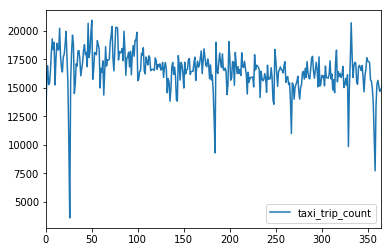

In [69]:
tlc_df_MSG_by_day_hour[['taxi_date', 'taxi_trip_count']].plot()

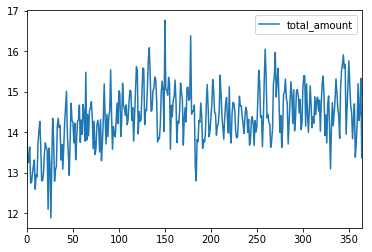

In [70]:
tlc_df_MSG_by_day_hour[['taxi_date', 'total_amount']].plot()

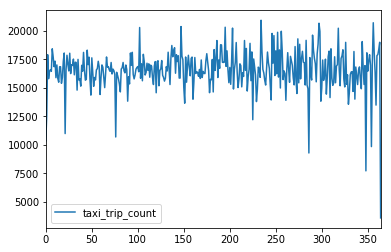

In [71]:
tlc_agg = tlc_df_MSG_by_day_hour.groupby(['hour'], as_index=False).sum()
tlc_agg[['taxi_trip_count']].plot()

In [73]:
# read in NYC street shapefile
'''
shapefile taken from https://geo.nyu.edu/catalog/nyu_2451_34565

'''
ny_streets_raw = gp.read_file(proj_folder + '/data/nyu_2451_34565.shp')
ny_streets_raw = ny_streets_raw.to_crs(epsg=4326)
# only keep points within MSG buffer
ny_streets = ny_streets_raw[ny_streets_raw.geometry.intersects(MSG_gp.geometry[0])]

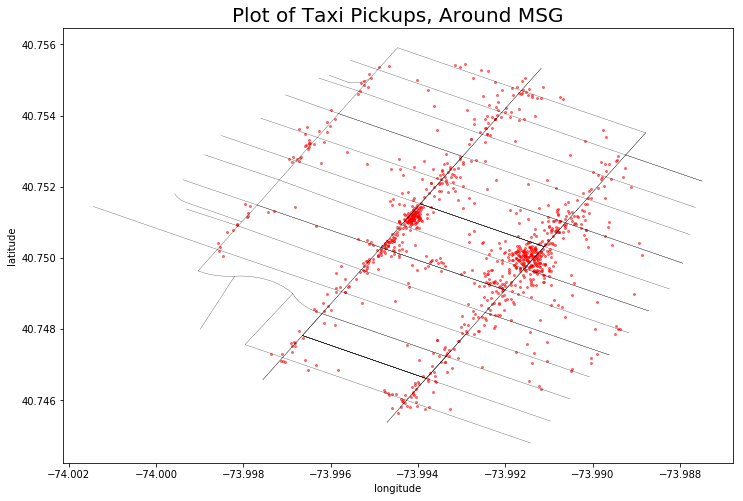

In [76]:
# is there a way to easily plot each color differently? I have this color column highlighting outliers!

MSG_sample = tlc_df_total_gp_subset.sample(n=1000)
#MSG_sample.lon = MSG_sample.geometry.x
#MSG_sample.lat = MSG_sample.geometry.y
f, (ax1) = plt.subplots(figsize=(12,8))
MSG_sample.plot(alpha=0.5, ax=ax1, color = 'red')
ny_streets['geometry'].plot(alpha=1, linewidth=0.25, ax=ax1, color = '0')
ax1.set_title("Plot of Taxi Pickups, Around MSG", fontsize=20)
plt.xlabel("longitude")
plt.ylabel("latitude")

## MSG anomaly analysis (isolation forest)

In [77]:
tlc_df_total_gp_subset.head()

,extra,fare_amount,mta_tax,passenger_count,pickup_latitude,pickup_longitude,tip_amount,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance,taxi_date,geometry,hour,total_mean,total_std
0,1.0,12.0,0.5,1.0,40.750111,-73.993896,3.25,17.05,2015-01-15 19:23:42,2015-01-15 19:05:39,1.59,2015-01-15,POINT (-73.993896484375 40.7501106262207),19,14.388696,10.28093
11,0.5,7.5,0.5,1.0,40.751419,-73.993782,1.00,9.80,2015-01-10 20:43:26,2015-01-10 20:33:41,1.10,2015-01-10,POINT (-73.99378204345702 40.75141906738281),20,14.388696,10.28093
26,1.0,9.0,0.5,1.0,40.750080,-73.991127,0.00,10.80,2015-01-15 19:16:18,2015-01-15 19:05:42,1.53,2015-01-15,POINT (-73.99112701416014 40.75008010864258),19,14.388696,10.28093
64,0.0,7.0,0.5,1.0,40.750809,-73.990952,1.40,9.20,2015-01-04 13:53:17,2015-01-04 13:44:52,1.14,2015-01-04,POINT (-73.99095153808595 40.75080871582031),13,14.388696,10.28093
89,0.0,8.5,0.5,1.0,40.751350,-73.994003,0.00,9.30,2015-01-15 14:10:24,2015-01-15 14:00:45,1.20,2015-01-15,POINT (-73.99400329589844 40.75135040283203),14,14.388696,10.28093


In [78]:
X = tlc_df_MSG_by_day_hour[cluster_features]
X.head(2)

,total_amount,taxi_trip_count,holiday,weekend
0,14.025259,12623,1,0
1,13.242994,15700,1,1


In [79]:
#normalize columns
for i in X.columns:
    X[i] = (X[i] - X[i].mean()) / X[i].std()

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [80]:
train,test=train_test_split(X, random_state=999, test_size=0.3)
# fit the model
clf = IsolationForest(max_samples=100, random_state=999)
clf.fit(train)
y_pred = clf.predict(X)

In [81]:
tlc_df_MSG_by_day_hour['decision_function'] = clf.decision_function(X)

In [82]:
tlc_df_MSG_by_day_hour.sort_values(by='decision_function').head(10)

,taxi_date,taxi_trip_count,extra,fare_amount,mta_tax,passenger_count,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance,hour,day_of_week,weekend,holiday,decision_function
184,2015-07-04,9292,0.181877,10.633475,0.498547,1.740099,40.750523,-73.992691,1.037090,12.804399,2.509267,13.957275,5,1,1,-0.193926
358,2015-12-25,7725,0.197799,11.336958,0.497735,1.716246,40.750489,-73.992858,1.195188,13.724594,2.680350,14.889968,4,1,1,-0.173579
183,2015-07-03,12208,0.229030,10.850224,0.497665,1.706832,40.750409,-73.992841,1.085757,13.147170,2.458297,13.609682,4,1,1,-0.171610
330,2015-11-27,14923,0.402801,10.632849,0.499129,1.703277,40.750456,-73.992618,1.144208,13.096610,2.354944,14.676875,4,1,1,-0.161144
1,2015-01-02,15700,0.370924,10.948408,0.498726,1.741401,40.750415,-73.992797,0.978538,13.242994,2.319040,14.653822,4,1,1,-0.149428
357,2015-12-24,10696,0.360789,10.925206,0.497709,1.698111,40.750516,-73.992775,1.116998,13.386415,2.444831,13.223168,3,0,1,-0.147910
359,2015-12-26,13489,0.156053,11.964786,0.498814,1.753132,40.750380,-73.992679,1.169562,14.226324,2.512221,15.356439,5,1,1,-0.140620
46,2015-02-16,20667,0.177916,10.494484,0.498355,1.680215,40.750522,-73.992832,1.306227,12.940994,2.337091,14.010984,0,0,1,-0.140173
26,2015-01-27,3599,0.540156,9.298864,0.499444,1.718255,40.750558,-73.992998,1.165582,11.889330,2.206099,17.396777,1,0,0,-0.131284
329,2015-11-26,9852,0.253502,11.619671,0.497006,1.702395,40.750538,-73.993047,1.250675,14.115899,2.769345,15.062221,3,0,1,-0.127684


### K-Means Cluster Model Anomaly Detection

In [83]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.553504127302
For n_clusters =3, the average silhouette_score is :0.455795517637
For n_clusters =4, the average silhouette_score is :0.358963911101
For n_clusters =5, the average silhouette_score is :0.371119027524
For n_clusters =6, the average silhouette_score is :0.377409824979
For n_clusters =7, the average silhouette_score is :0.380532988226
For n_clusters =8, the average silhouette_score is :0.384608725064


In [84]:
n=2
KM=KMeans(n_clusters=n,random_state=999)
scor=KM.fit_predict(X)

res=pd.DataFrame(KM.transform(X))
res=pd.concat((res,pd.DataFrame(KM.fit_predict(X))),axis=1)
res.columns=list(range(n))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

In [85]:
tlc_df_MSG_by_day_hour['cluster'] = res.cluster
tlc_df_MSG_by_day_hour['km_score'] = res.score
tlc_df_MSG_by_day_hour['outlier'] = 0
tlc_df_MSG_by_day_hour.sort_values("km_score",ascending=False, inplace=True)

In [86]:
tlc_df_MSG_by_day_hour['outlier'][:10] = 1 

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [87]:
def set_color(Data1):
    if (Data1.outlier == 1):
        return "red"
    elif (Data1.cluster == 0):
        return "blue"
    elif (Data1.cluster == 1):
        return "cyan"
    else:
        return "green"

tlc_df_MSG_by_day_hour = tlc_df_MSG_by_day_hour.assign(color=tlc_df_MSG_by_day_hour.apply(set_color, axis=1))

In [88]:
tlc_df_MSG_by_day_hour.head()

,taxi_date,taxi_trip_count,extra,fare_amount,mta_tax,passenger_count,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance,hour,day_of_week,weekend,holiday,decision_function,cluster,km_score,outlier,color
26,2015-01-27,3599,0.540156,9.298864,0.499444,1.718255,40.750558,-73.992998,1.165582,11.889330,2.206099,17.396777,1,0,0,-0.131284,1,7.713714,1,red
358,2015-12-25,7725,0.197799,11.336958,0.497735,1.716246,40.750489,-73.992858,1.195188,13.724594,2.680350,14.889968,4,1,1,-0.173579,1,4.352168,1,red
25,2015-01-26,10358,0.181454,10.734186,0.498504,1.605040,40.750455,-73.992792,1.357831,13.219261,2.111629,10.119328,0,0,0,-0.087064,0,4.053982,1,red
184,2015-07-04,9292,0.181877,10.633475,0.498547,1.740099,40.750523,-73.992691,1.037090,12.804399,2.509267,13.957275,5,1,1,-0.193926,1,3.824968,1,red
23,2015-01-24,17744,0.167127,9.906702,0.498478,1.720751,40.750497,-73.992870,1.118242,12.103066,2.164807,14.082676,5,1,0,-0.084818,0,3.719762,1,red


In [89]:
tlc_df_by_day_w_z_scores = tlc_df_MSG_by_day_hour.merge(X, left_index=True, right_index=True)
z_score = tlc_df_by_day_w_z_scores[['taxi_date', 'km_score',  'total_amount_x',\
                          'taxi_trip_count_x', 'holiday_x', 'weekend_x', \
                                    'total_amount_y', 'taxi_trip_count_y', 'holiday_y', 'weekend_y']]
z_score.sort_values("km_score",ascending=False, inplace=True)
z_score.to_csv('MSG_clustered_by_day_w_z_scores.csv')

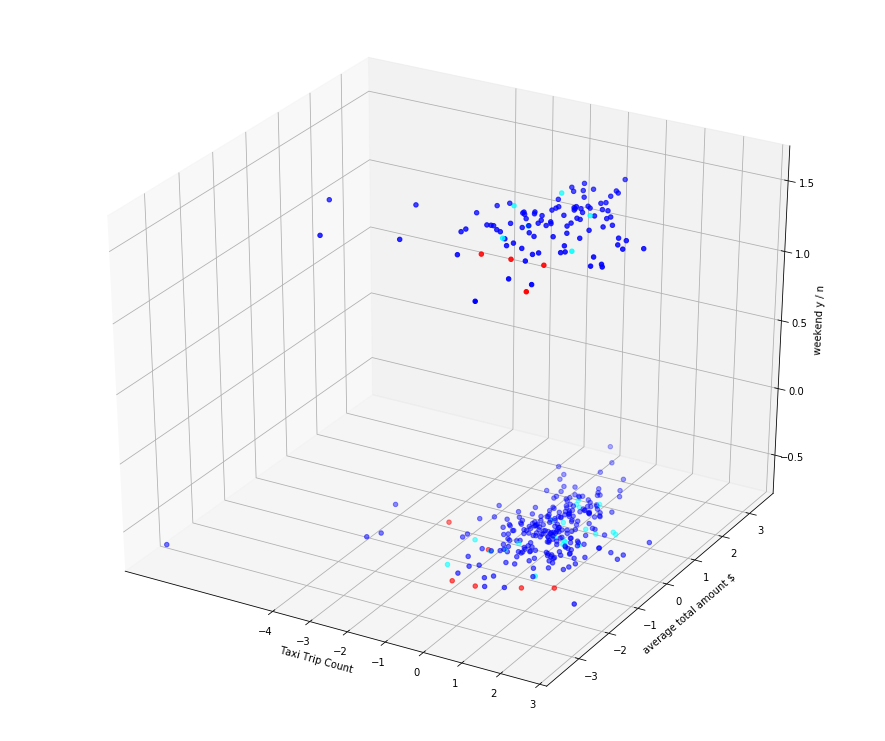

In [90]:
fig = plt.figure(figsize=(12,10))
ax = Axes3D(fig)

ax.scatter(X.taxi_trip_count, X.total_amount, X.weekend, c=tlc_df_MSG_by_day_hour.color)
ax.set_xlabel('Taxi Trip Count')
ax.set_ylabel('average total amount $')
ax.set_zlabel('weekend y / n')
# set x ticks and labels
ax.set_xticks(range(-4, 4, 1))
# change fontsize
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(10)
plt.show()

## Look at specific areas and see what times / dates around there are anomalies
### staten island ferry terminal (Whitehall between state & FDR) (40.702095, -74.012782)

In [91]:
latlon_list = [40.702095, -74.012782]
#only keep trips within a reasonable pickup lat / lon (without converting geometries)
tlc_df_total_subset = tlc_df_total[(tlc_df_total.pickup_latitude > (latlon_list[0] - 0.005)) & (tlc_df_total.pickup_latitude < (latlon_list[0] + 0.005))]
tlc_df_total_subset = tlc_df_total_subset[(tlc_df_total_subset.pickup_longitude > (latlon_list[1] - 0.005)) & (tlc_df_total_subset.pickup_longitude < (latlon_list[1] + 0.005))]

In [92]:
len(tlc_df_total_subset)

1173422

In [93]:
# convert to geopandas df
geometry = [Point(xy) for xy in zip(tlc_df_total_subset.pickup_longitude, tlc_df_total_subset.pickup_latitude)]
tlc_df_total_subset = tlc_df_total_subset.drop(['pickup_latitude', 'pickup_longitude'], axis=1)

In [94]:
crs = {'init': 'epsg:4326'}
tlc_df_total_gp = GeoDataFrame(tlc_df_total_subset, crs=crs, geometry=geometry)

In [95]:
# create MSG buffer 
d = {'latitude': latlon_list[0], 'longitude': latlon_list[1]}
MSG = pd.DataFrame(data=d, index=[0])
geometry_MSG = [Point(xy) for xy in zip(MSG.longitude, MSG.latitude)]
crs = {'init': 'epsg:4326'}
MSG_gp = GeoDataFrame(crs=crs, geometry=geometry_MSG)

In [96]:
#create buffer
MSG_gp['geometry'] = MSG_gp.geometry.buffer(.005)
MSG_gp.head()

,geometry
0,"POLYGON ((-74.00778200000001 40.702095, -74.00..."


In [97]:
# only keep points within MSG buffer
tlc_df_total_gp_subset = tlc_df_total_gp[tlc_df_total_gp.geometry.intersects(MSG_gp.geometry[0])]

In [98]:
tlc_df_total_gp_subset['hour'] = tlc_df_total_gp_subset.tpep_pickup_datetime.apply(lambda x: x.hour)

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [99]:
#subset to 6am or greater hours (to only capture relevant hours)
tlc_df_total_gp_subset = tlc_df_total_gp_subset[(tlc_df_total_gp_subset.hour >= 6)]

In [100]:
#take the mean of the taxi stats each day / hour
tlc_df_MSG_count = tlc_df_total_gp_subset.groupby(['taxi_date'], as_index=False)['extra'].count()
tlc_df_MSG_count.columns = ['taxi_date', 'taxi_trip_count']
tlc_df_MSG_count.head()

,taxi_date,taxi_trip_count
0,2015-01-01,1493
1,2015-01-02,1932
2,2015-01-03,1399
3,2015-01-04,917
4,2015-01-05,1997


In [101]:
#take the mean of the taxi stats each day / hour
tlc_df_MSG_mean = tlc_df_total_gp_subset.groupby(['taxi_date'], as_index=False).mean()
tlc_df_MSG_mean.head()

,taxi_date,extra,fare_amount,mta_tax,passenger_count,tip_amount,total_amount,trip_distance,hour
0,2015-01-01,0.087743,15.535633,0.498326,1.844608,1.011808,17.525780,4.397368,14.753516
1,2015-01-02,0.331522,15.528002,0.498965,1.862319,1.275688,18.035699,4.221444,15.022257
2,2015-01-03,0.122230,14.847748,0.497498,1.820586,1.346112,17.236112,4.028520,15.581844
3,2015-01-04,0.079607,15.923675,0.495093,1.704471,1.539531,18.565627,4.498103,14.818975
4,2015-01-05,0.396845,15.400100,0.499249,1.752629,1.758368,18.504071,4.256490,15.192789


In [102]:
tlc_df_MSG_by_day_hour = tlc_df_MSG_count.merge(tlc_df_MSG_mean, on=['taxi_date'])
tlc_df_MSG_by_day_hour.head()

,taxi_date,taxi_trip_count,extra,fare_amount,mta_tax,passenger_count,tip_amount,total_amount,trip_distance,hour
0,2015-01-01,1493,0.087743,15.535633,0.498326,1.844608,1.011808,17.525780,4.397368,14.753516
1,2015-01-02,1932,0.331522,15.528002,0.498965,1.862319,1.275688,18.035699,4.221444,15.022257
2,2015-01-03,1399,0.122230,14.847748,0.497498,1.820586,1.346112,17.236112,4.028520,15.581844
3,2015-01-04,917,0.079607,15.923675,0.495093,1.704471,1.539531,18.565627,4.498103,14.818975
4,2015-01-05,1997,0.396845,15.400100,0.499249,1.752629,1.758368,18.504071,4.256490,15.192789


In [103]:
tlc_df_MSG_by_day_hour['day_of_week'] = tlc_df_MSG_by_day_hour.taxi_date.apply(lambda x: x.weekday())

In [104]:
#control for Friday / Saturday nights
tlc_df_MSG_by_day_hour['weekend'] = 0
tlc_df_MSG_by_day_hour['weekend'][(tlc_df_MSG_by_day_hour['day_of_week'] == 4) | (tlc_df_MSG_by_day_hour['day_of_week'] == 5)] = 1

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [105]:
#add holiday dummy variable
tlc_df_MSG_by_day_hour['holiday'] = 0
tlc_df_MSG_by_day_hour['holiday'][tlc_df_MSG_by_day_hour['taxi_date'].isin(holidays_all.index.date)] = 1

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


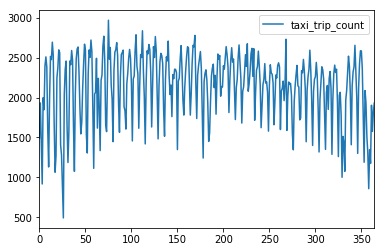

In [106]:
tlc_df_MSG_by_day_hour[['taxi_date', 'taxi_trip_count']].plot()

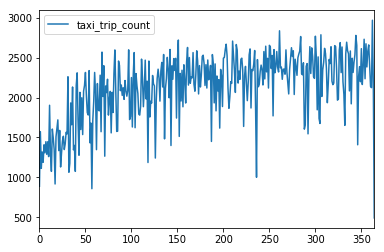

In [107]:
tlc_agg = tlc_df_MSG_by_day_hour.groupby(['hour'], as_index=False).sum()
tlc_agg[['taxi_trip_count']].plot()

In [108]:
# only keep points within buffer
ny_streets = ny_streets_raw[ny_streets_raw.geometry.intersects(MSG_gp.geometry[0])]

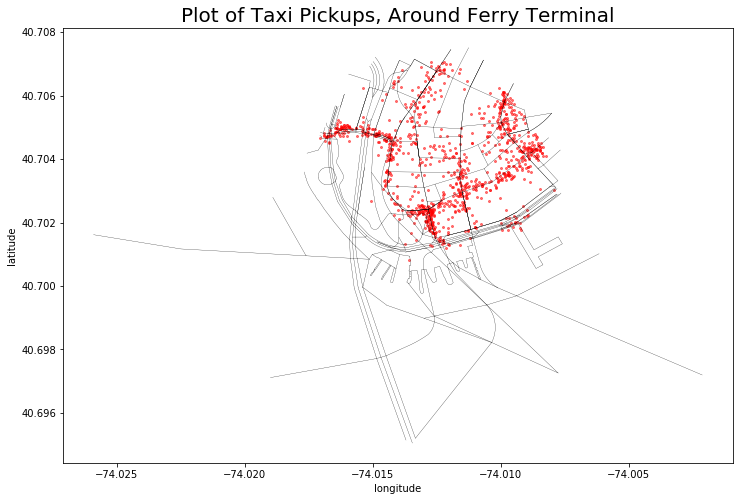

In [110]:
# is there a way to easily plot each color differently? I have this color column highlighting outliers!

MSG_sample = tlc_df_total_gp_subset.sample(n=1000)
#MSG_sample.lon = MSG_sample.geometry.x
#MSG_sample.lat = MSG_sample.geometry.y
f, (ax1) = plt.subplots(figsize=(12,8))
MSG_sample.plot(alpha=0.5, ax=ax1, color = 'red')
ny_streets['geometry'].plot(alpha=1, linewidth=0.25, ax=ax1, color = '0')
ax1.set_title("Plot of Taxi Pickups, Around Ferry Terminal", fontsize=20)
plt.xlabel("longitude")
plt.ylabel("latitude")

## Ferry Terminal anomaly analysis (isolation forest)

In [111]:
X = tlc_df_MSG_by_day_hour[cluster_features]
X.head(2)

,total_amount,taxi_trip_count,holiday,weekend
0,17.525780,1493,1,0
1,18.035699,1932,1,1


In [112]:
#normalize columns
for i in X.columns:
    X[i] = (X[i] - X[i].mean()) / X[i].std()

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [113]:
train,test=train_test_split(X, random_state=999, test_size=0.3)
# fit the model
clf = IsolationForest(max_samples=100, random_state=999)
clf.fit(train)
y_pred = clf.predict(X)

In [114]:
tlc_df_MSG_by_day_hour['decision_function'] = clf.decision_function(X)


In [115]:
tlc_df_MSG_by_day_hour.sort_values(by='decision_function').head(10)

,taxi_date,taxi_trip_count,extra,fare_amount,mta_tax,passenger_count,tip_amount,total_amount,trip_distance,hour,day_of_week,weekend,holiday,decision_function
358,2015-12-25,858,0.086247,16.057692,0.498252,1.860140,1.338473,18.382669,4.528030,15.304196,4,1,1,-0.168785
359,2015-12-26,1347,0.088344,15.741648,0.499258,1.891611,1.060839,17.800156,4.255768,15.312546,5,1,1,-0.154884
17,2015-01-18,1064,0.093515,14.353853,0.498590,1.739662,1.779784,17.114953,3.920461,15.016917,6,0,1,-0.148364
184,2015-07-04,1450,0.094483,15.036552,0.499655,1.933793,1.250986,17.326862,3.904883,15.677241,5,1,1,-0.143901
330,2015-11-27,1513,0.404494,15.114012,0.499339,1.835426,1.451989,17.909286,4.125023,15.595506,4,1,1,-0.137042
329,2015-11-26,1001,0.120879,16.615385,0.498002,1.786214,1.611299,19.283057,4.591299,15.800200,3,0,1,-0.129669
1,2015-01-02,1932,0.331522,15.528002,0.498965,1.862319,1.275688,18.035699,4.221444,15.022257,4,1,1,-0.119360
183,2015-07-03,1935,0.203876,15.451700,0.498708,1.894057,1.504181,18.083008,4.132078,16.012403,4,1,1,-0.118219
0,2015-01-01,1493,0.087743,15.535633,0.498326,1.844608,1.011808,17.525780,4.397368,14.753516,3,0,1,-0.111595
357,2015-12-24,1307,0.293803,16.628156,0.497322,1.843917,1.644828,19.701446,4.607559,14.476664,3,0,1,-0.109796


### K-Means Cluster Model Anomaly Detection

In [116]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.403277032708
For n_clusters =3, the average silhouette_score is :0.449826035826
For n_clusters =4, the average silhouette_score is :0.535684145328
For n_clusters =5, the average silhouette_score is :0.560098692117
For n_clusters =6, the average silhouette_score is :0.495498649112
For n_clusters =7, the average silhouette_score is :0.491377712238
For n_clusters =8, the average silhouette_score is :0.464427416681


In [117]:
n=5
KM=KMeans(n_clusters=n,random_state=999)
scor=KM.fit_predict(X)

res=pd.DataFrame(KM.transform(X))
res=pd.concat((res,pd.DataFrame(KM.fit_predict(X))),axis=1)
res.columns=list(range(n))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

In [118]:
tlc_df_MSG_by_day_hour['cluster'] = res.cluster
tlc_df_MSG_by_day_hour['km_score'] = res.score
tlc_df_MSG_by_day_hour['outlier'] = 0
tlc_df_MSG_by_day_hour.sort_values("km_score",ascending=False, inplace=True)

In [119]:
tlc_df_MSG_by_day_hour['outlier'][:10] = 1 

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [120]:
def set_color(Data1):
    if (Data1.outlier == 1):
        return "red"
    elif (Data1.cluster == 0):
        return "blue"
    elif (Data1.cluster == 1):
        return "cyan"
    else:
        return "green"

tlc_df_MSG_by_day_hour = tlc_df_MSG_by_day_hour.assign(color=tlc_df_MSG_by_day_hour.apply(set_color, axis=1))

In [121]:
tlc_df_MSG_by_day_hour.head()

,taxi_date,taxi_trip_count,extra,fare_amount,mta_tax,passenger_count,tip_amount,total_amount,trip_distance,hour,day_of_week,weekend,holiday,decision_function,cluster,km_score,outlier,color
358,2015-12-25,858,0.086247,16.057692,0.498252,1.860140,1.338473,18.382669,4.528030,15.304196,4,1,1,-0.168785,3,2.803750,1,red
26,2015-01-27,492,0.559959,14.055894,0.498984,1.650407,1.806911,17.297947,4.009919,16.902439,1,0,0,-0.075845,4,2.562101,1,red
315,2015-11-12,2240,0.404687,18.722772,0.496652,1.597768,2.893603,23.267179,4.905960,15.961161,3,0,1,-0.084602,3,2.395078,1,red
184,2015-07-04,1450,0.094483,15.036552,0.499655,1.933793,1.250986,17.326862,3.904883,15.677241,5,1,1,-0.143901,3,2.213518,1,red
359,2015-12-26,1347,0.088344,15.741648,0.499258,1.891611,1.060839,17.800156,4.255768,15.312546,5,1,1,-0.154884,3,2.191226,1,red


In [122]:
tlc_df_by_day_w_z_scores = tlc_df_MSG_by_day_hour.merge(X, left_index=True, right_index=True)
z_score = tlc_df_by_day_w_z_scores[['taxi_date', 'km_score',  'total_amount_x',\
                          'taxi_trip_count_x', 'holiday_x', 'weekend_x', \
                                    'total_amount_y', 'taxi_trip_count_y', 'holiday_y', 'weekend_y']]
z_score.sort_values("km_score",ascending=False, inplace=True)
z_score.to_csv('ferry_terminal_clustered_by_day_w_z_scores.csv')

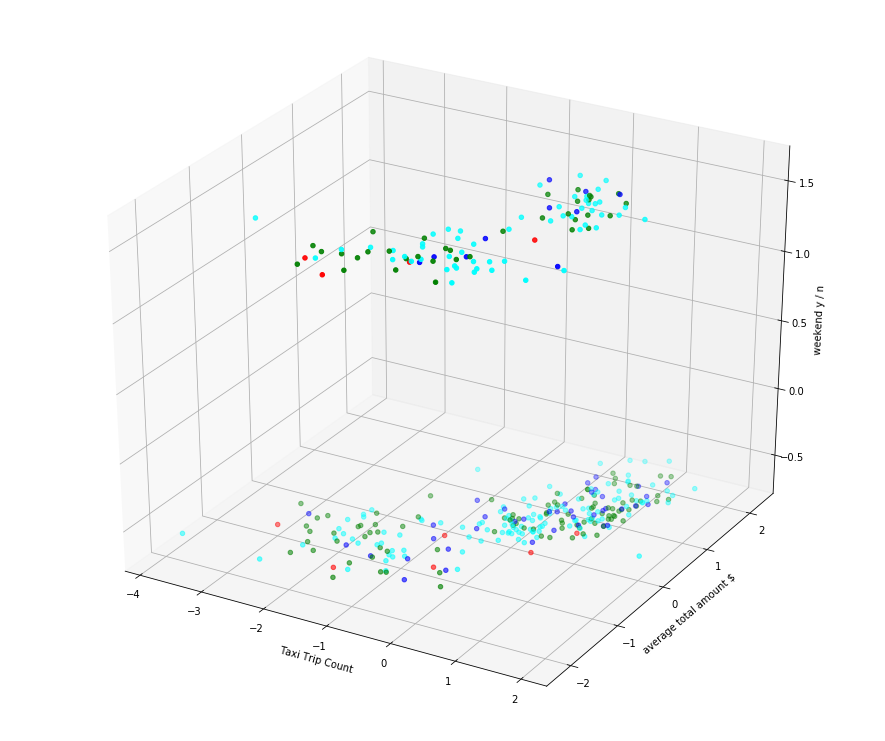

In [123]:
fig = plt.figure(figsize=(12,10))
ax = Axes3D(fig)

ax.scatter(X.taxi_trip_count, X.total_amount, X.weekend, c=tlc_df_MSG_by_day_hour.color)
ax.set_xlabel('Taxi Trip Count')
ax.set_ylabel('average total amount $')
ax.set_zlabel('weekend y / n')
# set x ticks and labels
ax.set_xticks(range(-4, 3, 1))
# change fontsize
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(10)
plt.show()

## Look at specific areas and see what times / dates around there are anomalies
### St. Patricks Cathedral (40.758477, -73.976223)

In [124]:
latlon_list = [40.758477, -73.976223]
#only keep trips within a reasonable pickup lat / lon (without converting geometries)
tlc_df_total_subset = tlc_df_total[(tlc_df_total.pickup_latitude > (latlon_list[0] - 0.005)) & (tlc_df_total.pickup_latitude < (latlon_list[0] + 0.005))]
tlc_df_total_subset = tlc_df_total_subset[(tlc_df_total_subset.pickup_longitude > (latlon_list[1] - 0.005)) & (tlc_df_total_subset.pickup_longitude < (latlon_list[1] + 0.005))]

In [125]:
len(tlc_df_total_subset)

7792747

In [126]:
# convert to geopandas df
geometry = [Point(xy) for xy in zip(tlc_df_total_subset.pickup_longitude, tlc_df_total_subset.pickup_latitude)]
tlc_df_total_subset = tlc_df_total_subset.drop(['pickup_latitude', 'pickup_longitude'], axis=1)

In [127]:
crs = {'init': 'epsg:4326'}
tlc_df_total_gp = GeoDataFrame(tlc_df_total_subset, crs=crs, geometry=geometry)

In [128]:
# create MSG buffer 
d = {'latitude': latlon_list[0], 'longitude': latlon_list[1]}
MSG = pd.DataFrame(data=d, index=[0])
geometry_MSG = [Point(xy) for xy in zip(MSG.longitude, MSG.latitude)]
crs = {'init': 'epsg:4326'}
MSG_gp = GeoDataFrame(crs=crs, geometry=geometry_MSG)

In [129]:
#create buffer
MSG_gp['geometry'] = MSG_gp.geometry.buffer(.005)
MSG_gp.head()

,geometry
0,"POLYGON ((-73.97122300000001 40.758477, -73.97..."


In [130]:
# only keep points within MSG buffer
tlc_df_total_gp_subset = tlc_df_total_gp[tlc_df_total_gp.geometry.intersects(MSG_gp.geometry[0])]

In [131]:
tlc_df_total_gp_subset['hour'] = tlc_df_total_gp_subset.tpep_pickup_datetime.apply(lambda x: x.hour)

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [132]:
#subset to 6am or greater hours (to only capture relevant hours)
tlc_df_total_gp_subset = tlc_df_total_gp_subset[(tlc_df_total_gp_subset.hour >= 6)]

In [133]:
#take the mean of the taxi stats each day / hour
tlc_df_MSG_count = tlc_df_total_gp_subset.groupby(['taxi_date'], as_index=False)['extra'].count()
tlc_df_MSG_count.columns = ['taxi_date', 'taxi_trip_count']
tlc_df_MSG_count.head()

,taxi_date,taxi_trip_count
0,2015-01-01,9851
1,2015-01-02,14694
2,2015-01-03,13942
3,2015-01-04,9734
4,2015-01-05,17522


In [134]:
#take the mean of the taxi stats each day / hour
tlc_df_MSG_mean = tlc_df_total_gp_subset.groupby(['taxi_date'], as_index=False).mean()
tlc_df_MSG_mean.head()

,taxi_date,extra,fare_amount,mta_tax,passenger_count,tip_amount,total_amount,trip_distance,hour
0,2015-01-01,0.132271,11.195391,0.496650,1.879809,0.690295,13.082524,2.630857,15.713836
1,2015-01-02,0.412856,10.987493,0.497006,1.828297,0.890612,13.319784,2.394649,15.717027
2,2015-01-03,0.096973,9.968837,0.498314,1.870033,0.774831,11.803571,2.126820,15.767322
3,2015-01-04,0.080799,11.214814,0.496558,1.809225,1.026378,13.449700,2.664027,15.340662
4,2015-01-05,0.450691,10.401895,0.497888,1.668930,1.332293,13.205840,2.320482,16.090857


In [135]:
tlc_df_MSG_by_day_hour = tlc_df_MSG_count.merge(tlc_df_MSG_mean, on=['taxi_date'])
tlc_df_MSG_by_day_hour.head()

,taxi_date,taxi_trip_count,extra,fare_amount,mta_tax,passenger_count,tip_amount,total_amount,trip_distance,hour
0,2015-01-01,9851,0.132271,11.195391,0.496650,1.879809,0.690295,13.082524,2.630857,15.713836
1,2015-01-02,14694,0.412856,10.987493,0.497006,1.828297,0.890612,13.319784,2.394649,15.717027
2,2015-01-03,13942,0.096973,9.968837,0.498314,1.870033,0.774831,11.803571,2.126820,15.767322
3,2015-01-04,9734,0.080799,11.214814,0.496558,1.809225,1.026378,13.449700,2.664027,15.340662
4,2015-01-05,17522,0.450691,10.401895,0.497888,1.668930,1.332293,13.205840,2.320482,16.090857


In [136]:
tlc_df_MSG_by_day_hour['day_of_week'] = tlc_df_MSG_by_day_hour.taxi_date.apply(lambda x: x.weekday())

In [137]:
#control for Friday / Saturday nights
tlc_df_MSG_by_day_hour['weekend'] = 0
tlc_df_MSG_by_day_hour['weekend'][(tlc_df_MSG_by_day_hour['day_of_week'] == 4) | (tlc_df_MSG_by_day_hour['day_of_week'] == 5)] = 1

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [138]:
#add holiday dummy variable
tlc_df_MSG_by_day_hour['holiday'] = 0
tlc_df_MSG_by_day_hour['holiday'][tlc_df_MSG_by_day_hour['taxi_date'].isin(holidays_all.index.date)] = 1

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


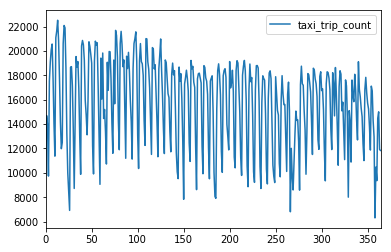

In [139]:
tlc_df_MSG_by_day_hour[['taxi_date', 'taxi_trip_count']].plot()

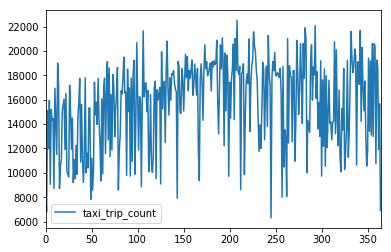

In [140]:
tlc_agg = tlc_df_MSG_by_day_hour.groupby(['hour'], as_index=False).sum()
tlc_agg[['taxi_trip_count']].plot()

In [141]:
# only keep points within buffer
ny_streets = ny_streets_raw[ny_streets_raw.geometry.intersects(MSG_gp.geometry[0])]

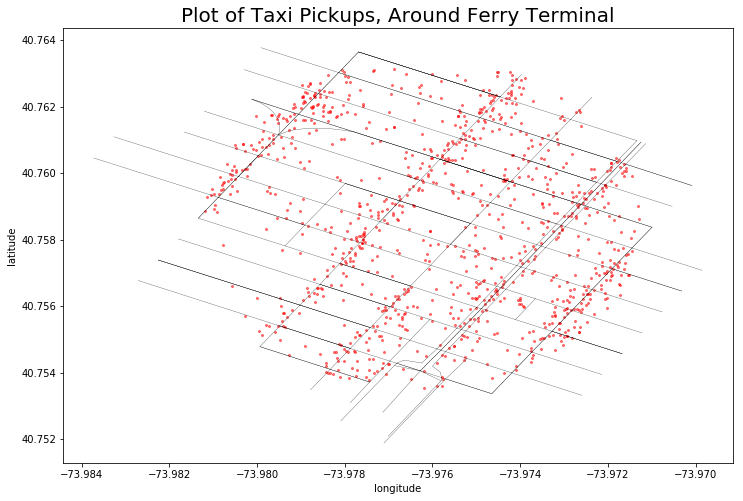

In [143]:
# is there a way to easily plot each color differently? I have this color column highlighting outliers!

MSG_sample = tlc_df_total_gp_subset.sample(n=1000)
#MSG_sample.lon = MSG_sample.geometry.x
#MSG_sample.lat = MSG_sample.geometry.y
f, (ax1) = plt.subplots(figsize=(12,8))
MSG_sample.plot(alpha=0.5, ax=ax1, color = 'red')
ny_streets['geometry'].plot(alpha=1, linewidth=0.25, ax=ax1, color = '0')
ax1.set_title("Plot of Taxi Pickups, Around Ferry Terminal", fontsize=20)
plt.xlabel("longitude")
plt.ylabel("latitude")

## Ferry Terminal anomaly analysis (isolation forest)

In [144]:
X = tlc_df_MSG_by_day_hour[cluster_features]
X.head(2)

,total_amount,taxi_trip_count,holiday,weekend
0,13.082524,9851,1,0
1,13.319784,14694,1,1


In [145]:
#normalize columns
for i in X.columns:
    X[i] = (X[i] - X[i].mean()) / X[i].std()

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [146]:
train,test=train_test_split(X, random_state=999, test_size=0.3)
# fit the model
clf = IsolationForest(max_samples=100, random_state=999)
clf.fit(train)
y_pred = clf.predict(X)

In [147]:
tlc_df_MSG_by_day_hour['decision_function'] = clf.decision_function(X)

In [148]:
tlc_df_MSG_by_day_hour.sort_values(by='decision_function').head(10)

,taxi_date,taxi_trip_count,extra,fare_amount,mta_tax,passenger_count,tip_amount,total_amount,trip_distance,hour,day_of_week,weekend,holiday,decision_function
184,2015-07-04,8058,0.112559,10.268616,0.498387,1.874535,0.818838,12.179671,2.397573,15.855423,5,1,1,-0.157032
358,2015-12-25,6301,0.121092,10.977702,0.498492,1.866212,0.869757,12.936712,2.411501,15.799873,4,1,1,-0.144115
183,2015-07-03,10016,0.209764,10.347444,0.498802,1.794229,0.997843,12.537167,2.335599,15.904153,4,1,1,-0.138932
329,2015-11-26,8002,0.115721,10.241003,0.498688,1.829418,0.914571,12.208679,2.307341,15.838040,3,0,1,-0.134965
314,2015-11-11,14670,0.172631,14.108384,0.497307,1.633947,2.218215,17.713420,2.781549,15.957873,2,0,1,-0.128104
330,2015-11-27,15101,0.420270,10.415668,0.498477,1.831998,1.004485,12.776366,2.156485,15.660817,4,1,1,-0.126445
359,2015-12-26,10473,0.118925,11.186910,0.498711,1.860880,0.942425,13.212404,2.326549,15.852382,5,1,1,-0.123675
1,2015-01-02,14694,0.412856,10.987493,0.497006,1.828297,0.890612,13.319784,2.394649,15.717027,4,1,1,-0.110906
283,2015-10-11,9884,0.100314,13.493368,0.497521,1.819304,1.403942,16.258519,3.031227,15.367463,6,0,1,-0.106486
17,2015-01-18,11979,0.060440,10.115911,0.498623,1.810168,1.080275,12.289541,2.314871,14.566575,6,0,1,-0.104545


### K-Means Cluster Model Anomaly Detection

In [149]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.366239288362
For n_clusters =3, the average silhouette_score is :0.42501891025
For n_clusters =4, the average silhouette_score is :0.497868722728
For n_clusters =5, the average silhouette_score is :0.53604534174
For n_clusters =6, the average silhouette_score is :0.483695621391
For n_clusters =7, the average silhouette_score is :0.483146327959
For n_clusters =8, the average silhouette_score is :0.463096427347


In [150]:
n=5
KM=KMeans(n_clusters=n,random_state=999)
scor=KM.fit_predict(X)

res=pd.DataFrame(KM.transform(X))
res=pd.concat((res,pd.DataFrame(KM.fit_predict(X))),axis=1)
res.columns=list(range(n))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

In [151]:
tlc_df_MSG_by_day_hour['cluster'] = res.cluster
tlc_df_MSG_by_day_hour['km_score'] = res.score
tlc_df_MSG_by_day_hour['outlier'] = 0
tlc_df_MSG_by_day_hour.sort_values("km_score",ascending=False, inplace=True)

In [152]:
tlc_df_MSG_by_day_hour['outlier'][:10] = 1 

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [153]:
def set_color(Data1):
    if (Data1.outlier == 1):
        return "red"
    elif (Data1.cluster == 0):
        return "blue"
    elif (Data1.cluster == 1):
        return "cyan"
    else:
        return "green"

tlc_df_MSG_by_day_hour = tlc_df_MSG_by_day_hour.assign(color=tlc_df_MSG_by_day_hour.apply(set_color, axis=1))

In [154]:
tlc_df_MSG_by_day_hour.head()

,taxi_date,taxi_trip_count,extra,fare_amount,mta_tax,passenger_count,tip_amount,total_amount,trip_distance,hour,day_of_week,weekend,holiday,decision_function,cluster,km_score,outlier,color
314,2015-11-11,14670,0.172631,14.108384,0.497307,1.633947,2.218215,17.713420,2.781549,15.957873,2,0,1,-0.128104,4,3.106105,1,red
358,2015-12-25,6301,0.121092,10.977702,0.498492,1.866212,0.869757,12.936712,2.411501,15.799873,4,1,1,-0.144115,4,2.759642,1,red
184,2015-07-04,8058,0.112559,10.268616,0.498387,1.874535,0.818838,12.179671,2.397573,15.855423,5,1,1,-0.157032,4,2.703985,1,red
315,2015-11-12,18637,0.367361,13.148200,0.497961,1.638890,1.998145,16.630629,2.526296,15.618715,3,0,1,-0.088161,4,2.674731,1,red
26,2015-01-27,6917,0.605904,8.645800,0.499711,1.670088,1.274087,11.377013,2.001424,17.447593,1,0,0,-0.104185,1,2.654121,1,red


In [155]:
tlc_df_by_day_w_z_scores = tlc_df_MSG_by_day_hour.merge(X, left_index=True, right_index=True)
z_score = tlc_df_by_day_w_z_scores[['taxi_date', 'km_score',  'total_amount_x',\
                          'taxi_trip_count_x', 'holiday_x', 'weekend_x', \
                                    'total_amount_y', 'taxi_trip_count_y', 'holiday_y', 'weekend_y']]
z_score.sort_values("km_score",ascending=False, inplace=True)
z_score.to_csv('Patricks_clustered_by_day_w_z_scores.csv')

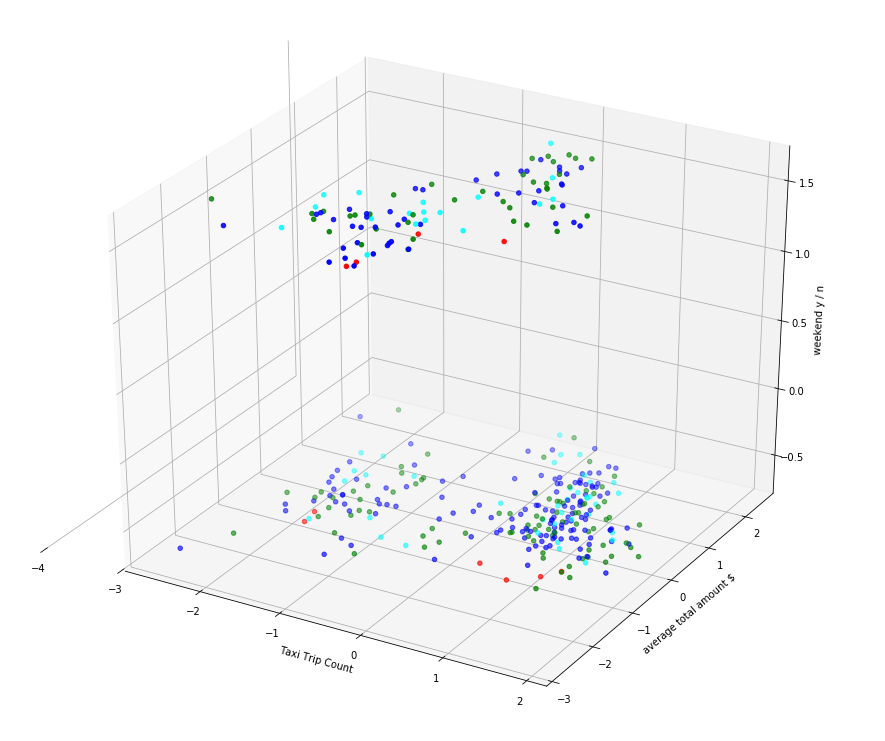

In [156]:
fig = plt.figure(figsize=(12,10))
ax = Axes3D(fig)

ax.scatter(X.taxi_trip_count, X.total_amount, X.weekend, c=tlc_df_MSG_by_day_hour.color)
ax.set_xlabel('Taxi Trip Count')
ax.set_ylabel('average total amount $')
ax.set_zlabel('weekend y / n')
# set x ticks and labels
ax.set_xticks(range(-4, 3, 1))
# change fontsize
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(10)
plt.show()

## Look at specific areas and see what times / dates around there are anomalies
### Metropolitan Opera (40.772567, -73.984089)

In [157]:
latlon_list = [40.772567, -73.984089]
#only keep trips within a reasonable pickup lat / lon (without converting geometries)
tlc_df_total_subset = tlc_df_total[(tlc_df_total.pickup_latitude > (latlon_list[0] - 0.005)) & (tlc_df_total.pickup_latitude < (latlon_list[0] + 0.005))]
tlc_df_total_subset = tlc_df_total_subset[(tlc_df_total_subset.pickup_longitude > (latlon_list[1] - 0.005)) & (tlc_df_total_subset.pickup_longitude < (latlon_list[1] + 0.005))]

In [158]:
len(tlc_df_total_subset)

4442324

In [159]:
# convert to geopandas df
geometry = [Point(xy) for xy in zip(tlc_df_total_subset.pickup_longitude, tlc_df_total_subset.pickup_latitude)]
tlc_df_total_subset = tlc_df_total_subset.drop(['pickup_latitude', 'pickup_longitude'], axis=1)

In [160]:
crs = {'init': 'epsg:4326'}
tlc_df_total_gp = GeoDataFrame(tlc_df_total_subset, crs=crs, geometry=geometry)

In [161]:
# create MSG buffer 
d = {'latitude': latlon_list[0], 'longitude': latlon_list[1]}
MSG = pd.DataFrame(data=d, index=[0])
geometry_MSG = [Point(xy) for xy in zip(MSG.longitude, MSG.latitude)]
crs = {'init': 'epsg:4326'}
MSG_gp = GeoDataFrame(crs=crs, geometry=geometry_MSG)

In [162]:
#create buffer
MSG_gp['geometry'] = MSG_gp.geometry.buffer(.005)
MSG_gp.head()

,geometry
0,"POLYGON ((-73.979089 40.772567, -73.9791130763..."


In [163]:
# only keep points within MSG buffer
tlc_df_total_gp_subset = tlc_df_total_gp[tlc_df_total_gp.geometry.intersects(MSG_gp.geometry[0])]

In [164]:
tlc_df_total_gp_subset['hour'] = tlc_df_total_gp_subset.tpep_pickup_datetime.apply(lambda x: x.hour)

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [165]:
#subset to 6am or greater hours (to only capture relevant hours)
tlc_df_total_gp_subset = tlc_df_total_gp_subset[(tlc_df_total_gp_subset.hour >= 6)]

In [166]:
#take the mean of the taxi stats each day / hour
tlc_df_MSG_count = tlc_df_total_gp_subset.groupby(['taxi_date'], as_index=False)['extra'].count()
tlc_df_MSG_count.columns = ['taxi_date', 'taxi_trip_count']
tlc_df_MSG_count.head()

,taxi_date,taxi_trip_count
0,2015-01-01,6812
1,2015-01-02,8831
2,2015-01-03,9994
3,2015-01-04,6804
4,2015-01-05,8894


In [167]:
#take the mean of the taxi stats each day / hour
tlc_df_MSG_mean = tlc_df_total_gp_subset.groupby(['taxi_date'], as_index=False).mean()
tlc_df_MSG_mean.head()

,taxi_date,extra,fare_amount,mta_tax,passenger_count,tip_amount,total_amount,trip_distance,hour
0,2015-01-01,0.161039,9.767104,0.498238,1.793453,0.951835,11.798260,2.260106,16.329419
1,2015-01-02,0.435172,10.175794,0.498358,1.740007,1.048113,12.558940,2.160236,16.292606
2,2015-01-03,0.146038,9.502772,0.498749,1.768561,0.966344,11.494175,2.055523,16.557034
3,2015-01-04,0.095826,9.754453,0.498383,1.722516,1.096748,11.856711,2.262237,15.334656
4,2015-01-05,0.376715,9.611817,0.498932,1.644929,1.145341,12.024667,2.099014,14.915449


In [168]:
tlc_df_MSG_by_day_hour = tlc_df_MSG_count.merge(tlc_df_MSG_mean, on=['taxi_date'])
tlc_df_MSG_by_day_hour.head()

,taxi_date,taxi_trip_count,extra,fare_amount,mta_tax,passenger_count,tip_amount,total_amount,trip_distance,hour
0,2015-01-01,6812,0.161039,9.767104,0.498238,1.793453,0.951835,11.798260,2.260106,16.329419
1,2015-01-02,8831,0.435172,10.175794,0.498358,1.740007,1.048113,12.558940,2.160236,16.292606
2,2015-01-03,9994,0.146038,9.502772,0.498749,1.768561,0.966344,11.494175,2.055523,16.557034
3,2015-01-04,6804,0.095826,9.754453,0.498383,1.722516,1.096748,11.856711,2.262237,15.334656
4,2015-01-05,8894,0.376715,9.611817,0.498932,1.644929,1.145341,12.024667,2.099014,14.915449


In [169]:
tlc_df_MSG_by_day_hour['day_of_week'] = tlc_df_MSG_by_day_hour.taxi_date.apply(lambda x: x.weekday())

In [170]:
#control for Friday / Saturday nights
tlc_df_MSG_by_day_hour['weekend'] = 0
tlc_df_MSG_by_day_hour['weekend'][(tlc_df_MSG_by_day_hour['day_of_week'] == 4) | (tlc_df_MSG_by_day_hour['day_of_week'] == 5)] = 1

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [171]:
#add holiday dummy variable
tlc_df_MSG_by_day_hour['holiday'] = 0
tlc_df_MSG_by_day_hour['holiday'][tlc_df_MSG_by_day_hour['taxi_date'].isin(holidays_all.index.date)] = 1

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


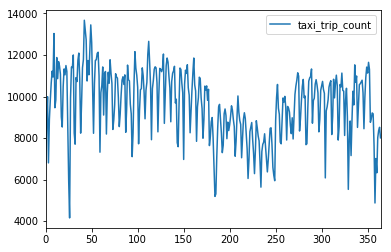

In [172]:
tlc_df_MSG_by_day_hour[['taxi_date', 'taxi_trip_count']].plot()

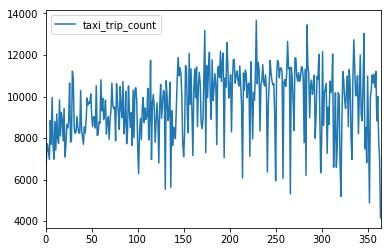

In [173]:
tlc_agg = tlc_df_MSG_by_day_hour.groupby(['hour'], as_index=False).sum()
tlc_agg[['taxi_trip_count']].plot()

In [174]:
# only keep points within buffer
ny_streets = ny_streets_raw[ny_streets_raw.geometry.intersects(MSG_gp.geometry[0])]

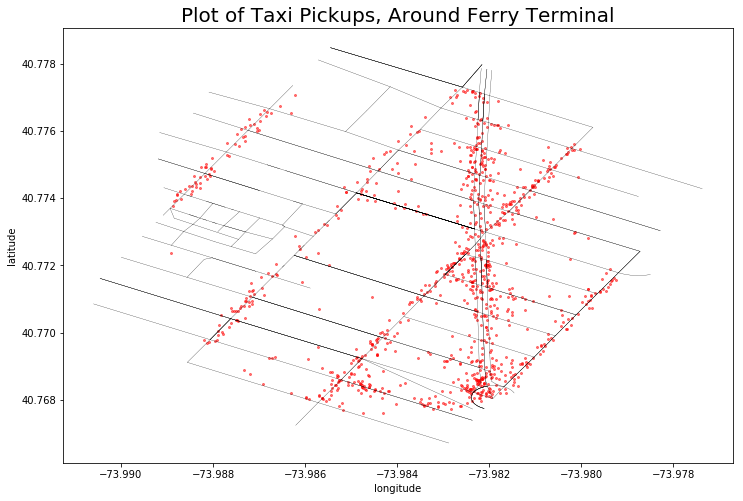

In [176]:
# is there a way to easily plot each color differently? I have this color column highlighting outliers!

MSG_sample = tlc_df_total_gp_subset.sample(n=1000)
#MSG_sample.lon = MSG_sample.geometry.x
#MSG_sample.lat = MSG_sample.geometry.y
f, (ax1) = plt.subplots(figsize=(12,8))
MSG_sample.plot(alpha=0.5, ax=ax1, color = 'red')
ny_streets['geometry'].plot(alpha=1, linewidth=0.25, ax=ax1, color = '0')
ax1.set_title("Plot of Taxi Pickups, Around Ferry Terminal", fontsize=20)
plt.xlabel("longitude")
plt.ylabel("latitude")

## Ferry Terminal anomaly analysis (isolation forest)

In [177]:
X = tlc_df_MSG_by_day_hour[cluster_features]
X.head(2)

,total_amount,taxi_trip_count,holiday,weekend
0,11.79826,6812,1,0
1,12.55894,8831,1,1


In [178]:
#normalize columns
for i in X.columns:
    X[i] = (X[i] - X[i].mean()) / X[i].std()

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [179]:
train,test=train_test_split(X, random_state=999, test_size=0.3)
# fit the model
clf = IsolationForest(max_samples=100, random_state=999)
clf.fit(train)
y_pred = clf.predict(X)

In [180]:
tlc_df_MSG_by_day_hour['decision_function'] = clf.decision_function(X)


In [181]:
tlc_df_MSG_by_day_hour.sort_values(by='decision_function').head(10)

,taxi_date,taxi_trip_count,extra,fare_amount,mta_tax,passenger_count,tip_amount,total_amount,trip_distance,hour,day_of_week,weekend,holiday,decision_function
184,2015-07-04,5189,0.133648,9.823112,0.499325,1.770283,1.061495,11.892943,2.308676,16.129890,5,1,1,-0.174683
358,2015-12-25,4872,0.135160,10.231835,0.498461,1.810345,1.131640,12.418918,2.373629,16.355296,4,1,1,-0.157569
183,2015-07-03,6589,0.237821,9.874032,0.499089,1.739869,1.118133,12.128746,2.262576,16.090909,4,1,1,-0.150046
359,2015-12-26,7014,0.152695,10.064229,0.498788,1.785429,1.048412,12.136784,2.087648,16.688908,5,1,1,-0.145473
330,2015-11-27,7886,0.450418,9.689196,0.499049,1.768070,1.108073,12.112073,2.099680,16.659396,4,1,1,-0.135645
1,2015-01-02,8831,0.435172,10.175794,0.498358,1.740007,1.048113,12.558940,2.160236,16.292606,4,1,1,-0.118176
17,2015-01-18,9016,0.088621,9.165983,0.499168,1.756100,1.125694,11.256107,2.025373,15.118345,6,0,1,-0.117162
329,2015-11-26,5528,0.121382,11.008683,0.498191,1.784913,1.340467,13.398395,2.503840,15.360166,3,0,1,-0.115565
248,2015-09-06,6204,0.115812,10.233881,0.498469,1.736622,1.126123,12.382926,2.338691,15.767569,6,0,1,-0.115175
249,2015-09-07,5945,0.115980,10.030530,0.497981,1.762153,1.189357,12.314932,2.422589,15.642220,0,0,1,-0.114900


### K-Means Cluster Model Anomaly Detection

In [190]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.518818200327
For n_clusters =3, the average silhouette_score is :0.43531484534
For n_clusters =4, the average silhouette_score is :0.422758154008
For n_clusters =5, the average silhouette_score is :0.418526285952
For n_clusters =6, the average silhouette_score is :0.367145369759
For n_clusters =7, the average silhouette_score is :0.374875764167
For n_clusters =8, the average silhouette_score is :0.380929929364


In [191]:
n=2
KM=KMeans(n_clusters=n,random_state=999)
scor=KM.fit_predict(X)

res=pd.DataFrame(KM.transform(X))
res=pd.concat((res,pd.DataFrame(KM.fit_predict(X))),axis=1)
res.columns=list(range(n))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

In [192]:
tlc_df_MSG_by_day_hour['cluster'] = res.cluster
tlc_df_MSG_by_day_hour['km_score'] = res.score
tlc_df_MSG_by_day_hour['outlier'] = 0
tlc_df_MSG_by_day_hour.sort_values("km_score",ascending=False, inplace=True)

In [193]:
tlc_df_MSG_by_day_hour['outlier'][:10] = 1 

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [194]:
def set_color(Data1):
    if (Data1.outlier == 1):
        return "red"
    elif (Data1.cluster == 0):
        return "blue"
    elif (Data1.cluster == 1):
        return "cyan"
    else:
        return "green"

tlc_df_MSG_by_day_hour = tlc_df_MSG_by_day_hour.assign(color=tlc_df_MSG_by_day_hour.apply(set_color, axis=1))

In [195]:
tlc_df_MSG_by_day_hour.head()

,taxi_date,taxi_trip_count,extra,fare_amount,mta_tax,passenger_count,tip_amount,total_amount,trip_distance,hour,day_of_week,weekend,holiday,decision_function,cluster,km_score,outlier,color
26,2015-01-27,4153,0.541175,8.423910,0.499639,1.750301,1.139829,10.929384,1.901832,17.674934,1,0,0,-0.101466,1,4.725342,1,red
185,2015-07-05,5309,0.108778,9.749765,0.498870,1.727444,1.123016,11.912140,2.275265,15.690526,6,0,0,-0.084747,1,3.379888,1,red
9,2015-01-10,13036,0.151120,9.931635,0.499770,1.719316,1.150161,12.067715,2.092310,16.294185,5,1,0,-0.076348,1,3.064503,1,red
304,2015-11-01,6080,0.138322,12.202681,0.497533,1.801151,1.475622,14.822975,2.695755,15.550000,6,0,0,-0.070393,1,3.042290,1,red
2,2015-01-03,9994,0.146038,9.502772,0.498749,1.768561,0.966344,11.494175,2.055523,16.557034,5,1,0,-0.053106,1,2.892642,1,red


In [196]:
tlc_df_by_day_w_z_scores = tlc_df_MSG_by_day_hour.merge(X, left_index=True, right_index=True)
z_score = tlc_df_by_day_w_z_scores[['taxi_date', 'km_score',  'total_amount_x',\
                          'taxi_trip_count_x', 'holiday_x', 'weekend_x', \
                                    'total_amount_y', 'taxi_trip_count_y', 'holiday_y', 'weekend_y']]
z_score.sort_values("km_score",ascending=False, inplace=True)
z_score.to_csv('met_opera_clustered_by_day_w_z_scores.csv')

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


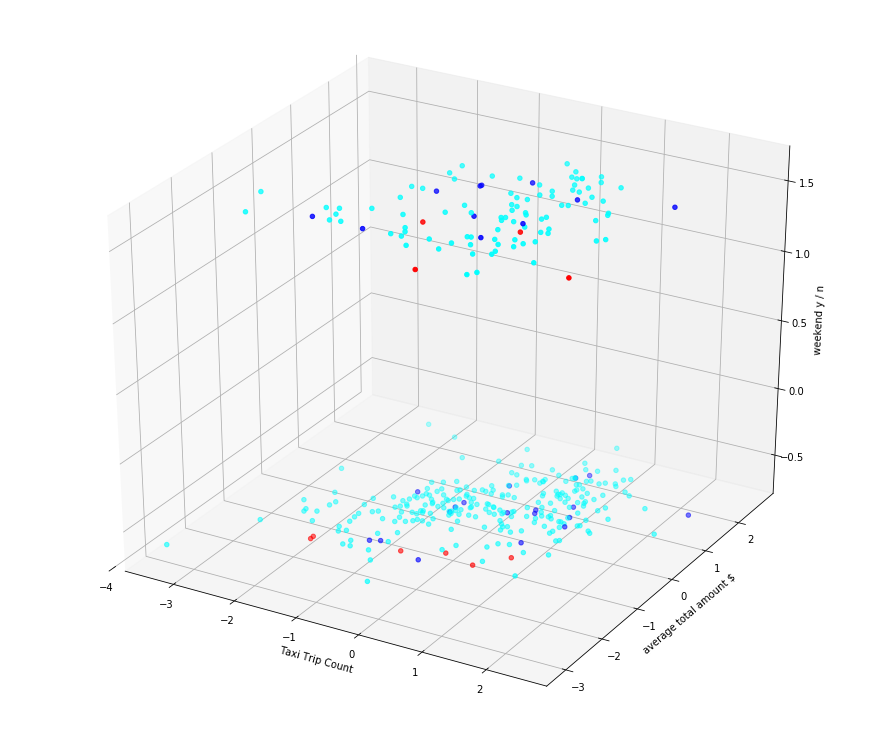

In [197]:
fig = plt.figure(figsize=(12,10))
ax = Axes3D(fig)

ax.scatter(X.taxi_trip_count, X.total_amount, X.weekend, c=tlc_df_MSG_by_day_hour.color)
ax.set_xlabel('Taxi Trip Count')
ax.set_ylabel('average total amount $')
ax.set_zlabel('weekend y / n')
# set x ticks and labels
ax.set_xticks(range(-4, 3, 1))
# change fontsize
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(10)
plt.show()